## Holt winters model

In [ ]:
## Train Test Split

train_data = df.iloc[:108] # Goes up to but not including 108
test_data = df.iloc[108:]

## Fitting the Model

from statsmodels.tsa.holtwinters import ExponentialSmoothing

fitted_model = ExponentialSmoothing(train_data['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit()

## Evaluating Model against Test Set

# YOU CAN SAFELY IGNORE WARNINGS HERE!
# THIS WILL NOT AFFECT YOUR FORECAST, IT'S JUST SOMETHING STATSMODELS NEEDS TO UPDATE UPON NEXT RELEASE.
test_predictions = fitted_model.forecast(36).rename('HW Forecast')

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [ ]:
## Forecasting into Future

final_model = ExponentialSmoothing(df['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit()

forecast_predictions = final_model.forecast(36)

# Stationarity
Time series data is said to be <em>stationary</em> if it does <em>not</em> exhibit trends or seasonality. That is, the mean, variance and covariance should be the same for any segment of the series, and are not functions of time.<br>
The file <tt>samples.csv</tt> contains made-up datasets that illustrate stationary and non-stationary data.

<div class="alert alert-info"><h3>For Further Reading:</h3>
<strong>
<a href='https://otexts.com/fpp2/stationarity.html'>Forecasting: Principles and Practice</a></strong>&nbsp;&nbsp;<font color=black>Stationarity and differencing</font></div>

# Differencing
## First Order Differencing
Non-stationary data can be made to look stationary through <em>differencing</em>. A simple method called <em>first order differencing</em> calculates the difference between consecutive observations.

&nbsp;&nbsp;&nbsp;&nbsp;$y^{\prime}_t = y_t - y_{t-1}$

In this way a linear trend is transformed into a horizontal set of values.


In [23]:
# Calculate the first difference of the non-stationary dataset "b"
df2['d1b'] = df2['b'] - df2['b'].shift(1)

df2[['b','d1b']].head()

,b,d1b
1950-01-01,27,NaN
1950-02-01,22,-5.0
1950-03-01,17,-5.0
1950-04-01,15,-2.0
1950-05-01,13,-2.0


## Second order differencing
Sometimes the first difference is not enough to attain stationarity, particularly if the trend is not linear. We can difference the already differenced values again to obtain a second order set of values.

&nbsp;&nbsp;&nbsp;&nbsp;$\begin{split}y_{t}^{\prime\prime} &= y_{t}^{\prime} - y_{t-1}^{\prime} \\
&= (y_t - y_{t-1}) - (y_{t-1} - y_{t-2}) \\
&= y_t - 2y_{t-1} + y_{t-2}\end{split}$

# First we'll look at the first order difference of dataset "c"
df2['d1c'] = df2['c'].diff()

df2['d1c'].plot(title="FIRST ORDER DIFFERENCE").autoscale(axis='x',tight=True);

# Introduction to ARIMA Models
We'll investigate a variety of different forecasting models in upcoming sections, but they all stem from ARIMA.

<strong>ARIMA</strong>, or <em>Autoregressive Integrated Moving Average</em> is actually a combination of 3 models:
* <strong>AR(p)</strong> Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period
* <strong>I(d)</strong> Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary
* <strong>MA(q)</strong> Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

<strong>Moving Averages</strong> we've already seen with EWMA and the Holt-Winters Method.<br>
<strong>Integration</strong> will apply differencing to make a time series stationary, which ARIMA requires.<br>
<strong>Autoregression</strong> is explained in detail in the next section. Here we're going to correlate a current time series with a lagged version of the same series.<br>
Once we understand the components, we'll investigate how to best choose the $p$, $d$ and $q$ values required by the model.

## Autocorrelation Function / Partial Autocorrelation Function

<h3>For Further Reading:</h3>
<strong>
<a href='https://en.wikipedia.org/wiki/Autocovariance'>Wikipedia:</a></strong>&nbsp;&nbsp;<font color=black>Autocovariance</font><br>
<strong>
<a href='https://otexts.com/fpp2/autocorrelation.html'>Forecasting: Principles and Practice</a></strong>&nbsp;&nbsp;<font color=black>Autocorrelation</font><br>
<strong>
<a href='https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4463.htm'>NIST Statistics Handbook</a></strong>&nbsp;&nbsp;<font color=black>Partial Autocorrelation Plot</font></div>


In [2]:
# Import the models we'll be using in this section
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols

In [6]:
arr3 = acf(df['a'])
arr3

array([ 1.   , -0.5  , -0.2  ,  0.275, -0.075])

In [7]:
arr4 = pacf_yw(df['a'],nlags=4,method='mle')
arr4

array([ 1.        , -0.5       , -0.6       , -0.38541667, -0.40563273])

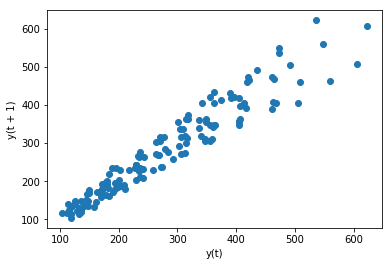

In [10]:
from pandas.plotting import lag_plot

lag_plot(df1['Thousands of Passengers']);

In [12]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

## Autoregressive Model

In an autoregression model, we forecast using a linear combination of <em>past values</em> of the variable. The term <em>autoregression</em> describes a regression of the variable against itself. An autoregression is run against a set of <em>lagged values</em> of order $p$.

### $y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}$

where $c$ is a constant, $\phi_{1}$ and $\phi_{2}$ are lag coefficients up to order $p$, and $\varepsilon_{t}$ is white noise.


In [ ]:
from statsmodels.tsa.ar_model import AR,ARResults

## Fit an AR(1) Model

In [7]:
model = AR(train['PopEst'])
AR1fit = model.fit(maxlag=1,method='mle')
print(f'Lag: {AR1fit.k_ar}')
print(f'Coefficients:\n{AR1fit.params}')

Lag: 1
Coefficients:
const        132.578420
L1.PopEst      0.999583
dtype: float64


<div class="alert alert-info"><strong>NOTE: </strong>There's a slight difference between the object returned by the Holt-Winters Exponential Smoothing <tt>.fit()</tt> method and that returned by AR. The Holt-Winters object uses <tt>.forecast()</tt> for predicted values, while AR uses <tt>.predict()</tt>.</div>

In [8]:
# This is the general format for obtaining predictions
start=len(train)
end=len(train)+len(test)-1
predictions1 = AR1fit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')

## Fit an AR(2) Model

In [12]:
# Recall that our model was already created above based on the training set
AR2fit = model.fit(maxlag=2,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')

Lag: 2
Coefficients:
const        135.359186
L1.PopEst      1.996616
L2.PopEst     -0.997041
dtype: float64


In [18]:
from sklearn.metrics import mean_squared_error

labels = ['AR(1)','AR(2)','AR(11)']
preds = [predictions1, predictions2, predictions11]  # these are variables, not strings!

for i in range(3):
    error = mean_squared_error(test['PopEst'], preds[i])
    print(f'{labels[i]} Error: {error:11.10}')

AR(1) Error: 1545278.379
AR(2) Error: 53231.37611
AR(11) Error: 9032.545012


## Forecasting
Now we're ready to train our best model on the greatest amount of data, and fit it to future dates.

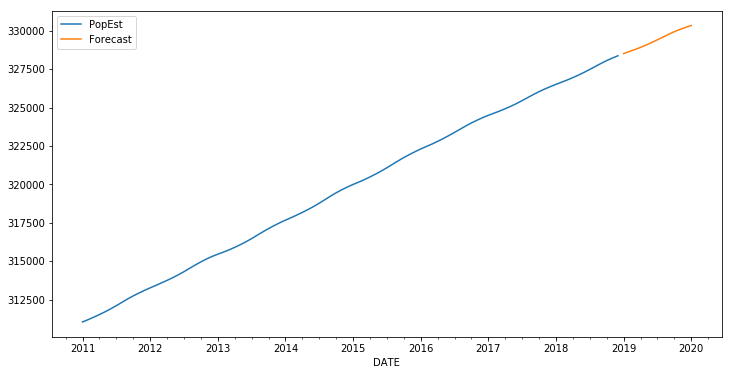

In [20]:
# First, retrain the model on the full dataset
model = AR(df['PopEst'])

# Next, fit the model
ARfit = model.fit(maxlag=11,method='mle')

# Make predictions
fcast = ARfit.predict(start=len(df), end=len(df)+12, dynamic=False).rename('Forecast')

# Plot the results
df['PopEst'].plot(legend=True)
fcast.plot(legend=True,figsize=(12,6));

## Descriptive Statistics and Tests


<h3>For Further Reading:</h3>
<strong>
<a href='https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test'>Wikipedia:</a></strong>&nbsp;&nbsp;<font color=black>Augmented Dickey–Fuller test</font><br>
<strong>
<a href='https://en.wikipedia.org/wiki/KPSS_test'>Wikipedia:</a></strong>&nbsp;&nbsp;<font color=black>Kwiatkowski-Phillips-Schmidt-Shin test</font><br>
<strong>
<a href='https://en.wikipedia.org/wiki/Granger_causality'>Wikipedia:</a></strong>&nbsp;&nbsp;<font color=black>Granger causality test</font><br>
<strong>
<a href='https://otexts.com/fpp2/accuracy.html'>Forecasting: Principles and Practice:</a></strong>&nbsp;&nbsp;<font color=black>Evaluating forecast accuracy</font>

</div>



In [2]:
from statsmodels.tsa.stattools import ccovf,ccf,periodogram

In [3]:
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin

In [4]:
from statsmodels.tools.eval_measures import mse, rmse, meanabs

# Alternative:
# from sklearn.metrics import mean_squared_error

##  Tests for Stationarity

Augmented Dickey-Fuller Test
To determine whether a series is stationary we can use the augmented Dickey-Fuller Test. In this test the null hypothesis states that  𝜙=1  (this is also called a unit test). The test returns several statistics we'll see in a moment. Our focus is on the p-value. A small p-value ( 𝑝<0.05 ) indicates strong evidence against the null hypothesis.

To demonstrate, we'll use a dataset we know is not stationary, the airline_passenger dataset. First, let's plot the data along with a 12-month rolling mean and standard deviation:

In [5]:
### Function for running the augmented Dickey-Fuller test


from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

# Granger Causality Tests
The <a href='https://en.wikipedia.org/wiki/Granger_causality'>Granger causality test</a> is a a hypothesis test to determine if one time series is useful in forecasting another. While it is fairly easy to measure correlations between series - when one goes up the other goes up, and vice versa - it's another thing to observe changes in one series correlated to changes in another after a consistent amount of time. This <em>may</em> indicate the presence of causality, that changes in the first series influenced the behavior of the second. However, it may also be that both series are affected by some third factor, just at different rates. Still, it can be useful if changes in one series can predict upcoming changes in another, whether there is causality or not. In this case we say that one series "Granger-causes" another.

In the case of two series, $y$ and $x$, the null hypothesis is that lagged values of $x$ do <em>not</em> explain variations in $y$.<br>
In other words, it assumes that $x_t$ doesn’t Granger-cause $y_t$.

The stattools <tt><strong>grangercausalitytests</strong></tt> function offers four tests for granger non-causality of 2 timeseries

For this example we'll use the samples.csv file, where columns 'a' and 'd' are stationary datasets.

In [ ]:
grangercausalitytests(df3[['b','d']],maxlag=3);

In [ ]:
from statsmodels.tools.eval_measures import aic, bic

## Exposing Seasonality with Month and Quarter Plots
Statsmodels has two plotting functions that group data by month and by quarter. Note that if the data appears as months, you should employ <em>resampling</em> with an aggregate function before running a quarter plot. These plots return a <tt>matplotlib.Figure</tt> object.
<div class="alert alert-info"><h3>Related Plot Methods:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.month_plot.html'>tsaplots.month_plot</a></strong><font color=black>(x)</font>&nbsp;&nbsp;&nbsp;&nbsp;Seasonal plot of monthly data<br>
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.quarter_plot.html'>tsaplots.quarter_plot</a></strong><font color=black>(x)</font>&nbsp;&nbsp;Seasonal plot of quarterly data</tt>
</div>

## Choosing ARIMA Orders

In [ ]:
from pmdarima import auto_arima

In [5]:
auto_arima(df2['Births'],error_action='ignore').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1226.077
Date:                Fri, 22 Mar 2019   AIC                           2460.154
Time:                        10:46:05   BIC                           2475.743
Sample:                             0   HQIC                          2466.350
                                - 365                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0132      0.014      0.975      0.330      -0.013       0.040
ar.L1          0.1299      0.059      2.217      0.027       0.015       0.245
ma.L1         -0.9694      0.016    -62.235      0.000      -1.000      -0.939
sigma2        48.9989      3.432     14.279      0.000      42.273      55.725
===================================================================================
Ljung-Box (Q):                       36.69   Jarque-Bera (JB):                26.17
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.58
Prob(H) (two-sided):                  0.85   Kurtosis:                         3.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [6]:
stepwise_fit = auto_arima(df2['Births'], start_p=0, start_q=0,
                          max_p=6, max_q=3, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0); AIC=2650.760, BIC=2658.555, Fit time=0.018 seconds
Fit ARIMA: order=(1, 1, 0); AIC=2565.234, BIC=2576.925, Fit time=0.139 seconds
Fit ARIMA: order=(0, 1, 1); AIC=2463.584, BIC=2475.275, Fit time=0.047 seconds
Fit ARIMA: order=(1, 1, 1); AIC=2460.154, BIC=2475.742, Fit time=0.105 seconds
Fit ARIMA: order=(1, 1, 2); AIC=2460.515, BIC=2480.000, Fit time=0.320 seconds
Fit ARIMA: order=(2, 1, 2); AIC=2462.045, BIC=2485.428, Fit time=0.373 seconds
Fit ARIMA: order=(2, 1, 1); AIC=2461.271, BIC=2480.757, Fit time=0.169 seconds
Total fit time: 1.175 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  364
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1226.077
Method:                       css-mle   S.D. of innovations              7.000
Date:                Fri, 22 Mar 2019   AIC                           2460.154
Time:                        10:46:20   BIC                           2475.742
Sample:                             1   HQIC                          2466.350
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0152      0.014      1.068      0.286      -0.013       0.043
ar.L1.D.y      0.1299      0.056      2.334      0.020       0.021       0.239
ma.L1.D.y     -0.9694      0.019    -51.415      0.000      -1.006      -0.932
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            7.6996           +0.0000j            7.6996            0.0000
MA.1            1.0316           +0.0000j            1.0316            0.0000
-----------------------------------------------------------------------------
"""

# ARMA(p,q) and ARIMA(p,d,q)
# Autoregressive Moving Averages
This section covers <em>Autoregressive Moving Averages</em> (ARMA) and <em>Autoregressive Integrated Moving Averages</em> (ARIMA).

Recall that an <strong>AR(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

while an <strong>MA(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = \mu + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

where $c$ is a constant, $\mu$ is the expectation of $y_{t}$ (often assumed to be zero), $\phi_1$ (phi-sub-one) is the AR lag coefficient, $\theta_1$ (theta-sub-one) is the MA lag coefficient, and $\varepsilon$ (epsilon) is white noise.

An <strong>ARMA(1,1)</strong> model therefore follows

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

ARMA models can be used on stationary datasets.

For non-stationary datasets with a trend component, ARIMA models apply a differencing coefficient as well.

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARMA.html'>arima_model.ARMA</a></strong><font color=black>(endog, order[, exog, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Autoregressive Moving Average ARMA(p,q) model<br>
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARMAResults.html'>arima_model.ARMAResults</a></strong><font color=black>(model, params[, …])</font>&nbsp;&nbsp;&nbsp;Class to hold results from fitting an ARMA model<br>
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html'>arima_model.ARIMA</a></strong><font color=black>(endog, order[, exog, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;Autoregressive Integrated Moving Average ARIMA(p,d,q) model<br>
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.html'>arima_model.ARIMAResults</a></strong><font color=black>(model, params[, …])</font>&nbsp;&nbsp;Class to hold results from fitting an ARIMA model<br>	
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.kalmanf.kalmanfilter.KalmanFilter.html'>kalmanf.kalmanfilter.KalmanFilter</a></strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Kalman Filter code intended for use with the ARMA model</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model'>Wikipedia</a></strong>&nbsp;&nbsp;<font color=black>Autoregressive–moving-average model</font><br>
<strong>
<a href='https://otexts.com/fpp2/non-seasonal-arima.html'>Forecasting: Principles and Practice</a></strong>&nbsp;&nbsp;<font color=black>Non-seasonal ARIMA models</font></div>

In [6]:
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders


### Obtain a month's worth of predicted values

In [10]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('ARMA(2,2) Predictions')

In [ ]:
model = ARMA(train['Births'],order=(2,2))
results = model.fit()
results.summary()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df2['Inventories'], model='additive')  # model='add' also works
result.plot();

In [ ]:
from statsmodels.tsa.statespace.tools import diff
df2['d1'] = diff(df2['Inventories'],k_diff=1)

# Equivalent to:
# df1['d1'] = df1['Inventories'] - df1['Inventories'].shift(1)

adf_test(df2['d1'],'Real Manufacturing and Trade Inventories')

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
model = SARIMAX(train['interpolated'],order=(0,1,3),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()